# Prediction Model

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# eda
from scipy.stats import zscore, randint
from sklearn.preprocessing import StandardScaler
# feature selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
# models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
# evaluation
from sklearn.metrics import mean_squared_error
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# store model
from joblib import dump, load

In [33]:
# load data 
%run load_data.ipynb

**Check distribution of features**


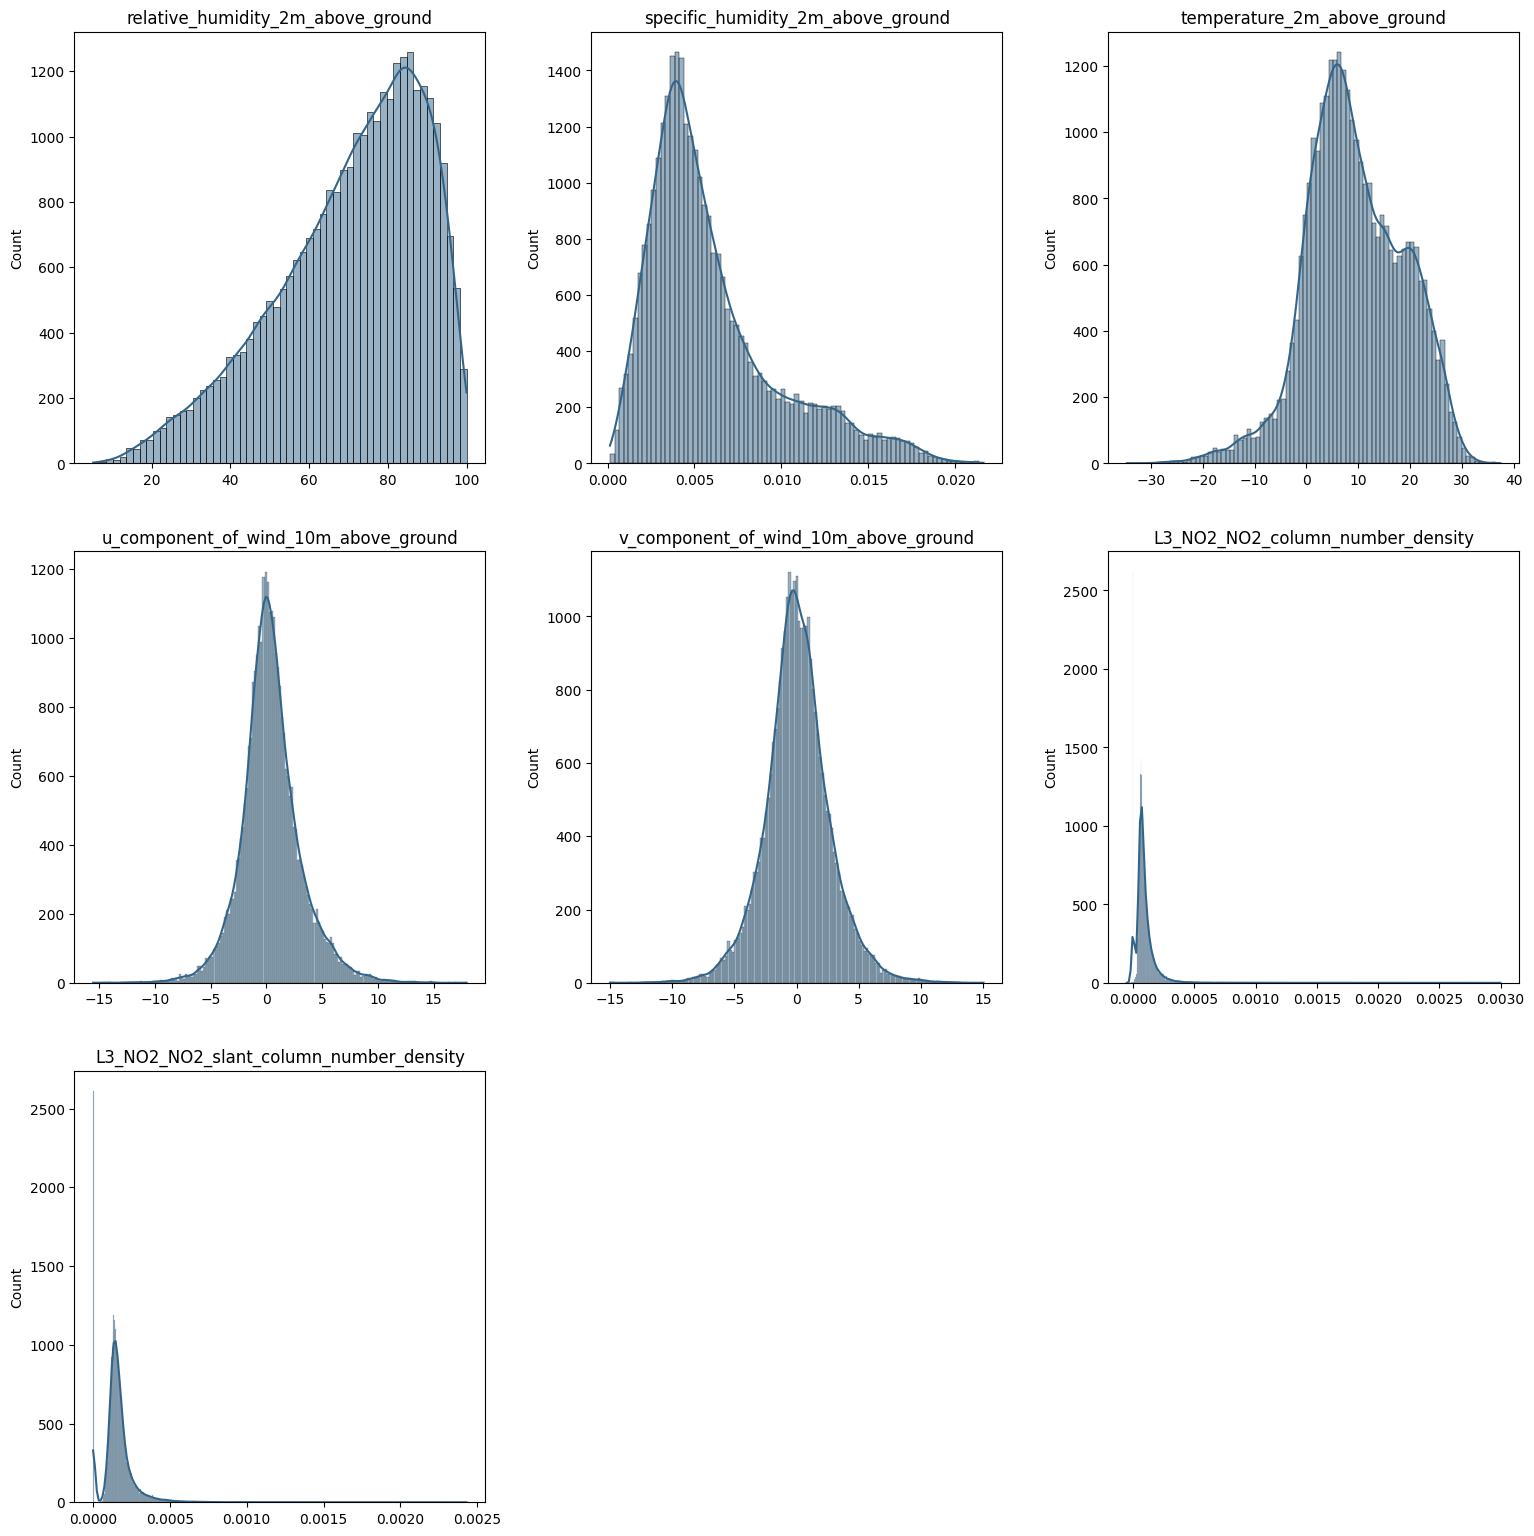

In [34]:
# plot features (max 7) 
%run histogram_9_features.ipynb

to_plot = train_X.columns[3:11]
plot_histograms(train_X[to_plot], train_X)

## Prediction Model 

In [35]:
# Impute missing value with imputer class
%run interpolation_imputer.ipynb

In [36]:
# Remove outlier class
%run outlier_zscore.ipynb

In [37]:
# Log transformer class
%run log_transformer.ipynb

**Preprocessing**

In [38]:
# columns with outliers
outlier_columns = ['L3_NO2_NO2_column_number_density',
                'L3_NO2_NO2_slant_column_number_density',
                'L3_NO2_sensor_altitude',
                'L3_NO2_solar_zenith_angle',
                'L3_NO2_stratospheric_NO2_column_number_density',
                'L3_NO2_tropospheric_NO2_column_number_density',
                'L3_O3_O3_effective_temperature',
                'L3_CO_CO_column_number_density',
                'L3_CO_H2O_column_number_density', 
                'L3_CO_sensor_altitude',
                'L3_CLOUD_cloud_optical_depth']

In [39]:
# columns with skewed n. distr. (may not relevant as no big effect on non-skewed so simply applied for every column)
skewed_columns = ['precipitable_water_entire_atmosphere',
                  'relative_humidity_2m_above_ground',
                  'specific_humidity_2m_above_ground',
                  'L3_CO_H2O_column_number_density',
                  'L3_CLOUD_cloud_top_height', 
                  'L3_CLOUD_cloud_top_pressure',
                  'L3_SO2_SO2_column_number_density_amf']

In [40]:
# columns with outlier
outliers = Pipeline(steps=[
    ('imputing', InterpolationImputer()),
    ('log_transform', LogTransformer()),
    ('outlier', ReplaceOutliersWithMean()), 
    ('standard_scaler', StandardScaler())
])

In [41]:
# columns with skewed dist
skewed = Pipeline(steps=[
    ('imputing', InterpolationImputer()),
    ('log_transform', LogTransformer()), 
    ('standard_scaler', StandardScaler())
])

In [42]:
# columns wout outliers
non_outliers = Pipeline(steps=[
    ('imputing', InterpolationImputer()),
    ('standard_scaler', StandardScaler()) 
])

In [43]:
preprocessing = ColumnTransformer([
    ('outliers', outliers, outlier_columns), 
    ('skewed', skewed, skewed_columns),    
    ('non_outliers', non_outliers, train_X.columns.drop(['Place_ID', 'Date'] + outlier_columns + skewed_columns).tolist())
])

**Features - Analysis of Variance (ANOVA)**

ANOVA cos numerical continous variables

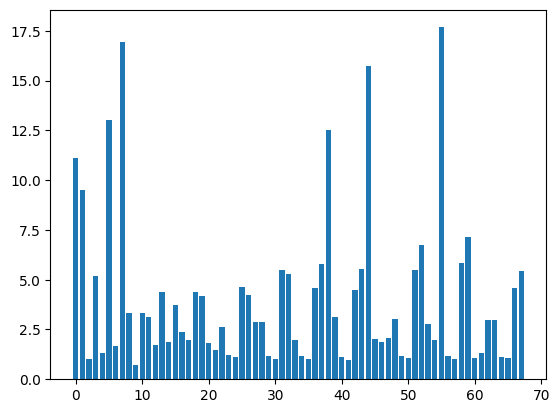

In [44]:
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('anova_feature_selection', SelectKBest(score_func=f_classif, k=28))

])

preprocessing_pipeline.fit(train_X, train_y)
X_transformed = preprocessing_pipeline.named_steps['preprocessing'].transform(train_X)

# Get ANOVA scores
anova_scores = preprocessing_pipeline.named_steps['anova_feature_selection'].scores_

# Plot
plt.bar([i for i in range(len(anova_scores))], anova_scores)
plt.show()

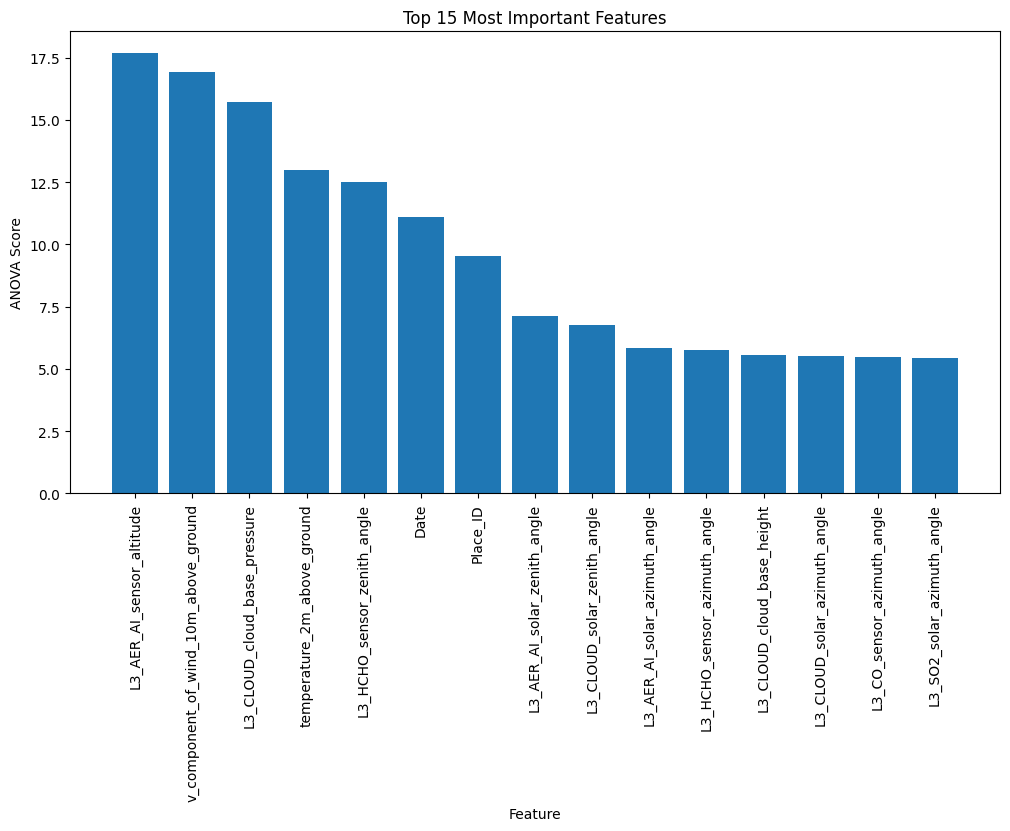

In [45]:
# plot most important features 

# Sort indices by ANOVA scores
sorted_indices = np.argsort(anova_scores)[::-1]

# Select top 15 features
top_15_indices = sorted_indices[:15]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_15_indices)), anova_scores[top_15_indices], align='center')
plt.xticks(range(len(top_15_indices)), train_X.columns[top_15_indices], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('ANOVA Score')
plt.title('Top 15 Most Important Features')
plt.show()

**Stacking and Boosting**

In [46]:
# stacking of heterogenous weak learners and xgboost
estimators_stacking = [
    ('lg', LinearRegression()),   
    ('knn', KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='auto', leaf_size=20, p=2)), 
    ('rf', RandomForestRegressor(random_state=RSEED, max_depth=2, n_estimators=30))
]

final_estimator = XGBRegressor(n_estimators = 30, max_depth = 5, random_state = 13)

stacking_boost = Pipeline([
    ('preprocessor', preprocessing),
    ('feature_selection', SelectKBest(score_func=f_classif, k = 50)),
    ('stacking', StackingRegressor(estimators = estimators_stacking, final_estimator = final_estimator))
])

In [48]:
stacking_boost.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('outliers',
                                                  Pipeline(steps=[('imputing',
                                                                   InterpolationImputer()),
                                                                  ('log_transform',
                                                                   LogTransformer()),
                                                                  ('outlier',
                                                                   ReplaceOutliersWithMean()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['L3_NO2_NO2_column_number_density',
                                                   'L3_NO2_NO2_slant_column_number_density',
                                                   'L3_NO2_sensor_altitude',
                                                   'L3_NO2_...
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=None,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=5,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=30,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=13, ...)))])

**Predicted target values and store**

In [49]:
y_train_predicted = stacking_boost.predict(train_X)
print("RMSE: {:.2f}".format(mean_squared_error(train_y, y_train_predicted, squared=False)))

RMSE: 29.57


In [51]:
y_test_predicted = stacking_boost.predict(test_X)
y_test_predicted

array([47.010723, 41.78733 , 44.53375 , ..., 48.14324 , 58.228966,
       50.707348], dtype=float32)

In [52]:
results_df = pd.DataFrame({
    'Date X Place_ID': test_X['Place_ID'] + " X " + test_X['Date'],
    'target': y_test_predicted.astype(int)
})

In [94]:
results_df.to_csv('submission.csv',sep = ',', index= False)

**Store Model**

In [28]:
dump(stacking_boost, 'air_pollution_model.joblib')

['air_pollution_model.joblib']